# Light GCN Sample Notebook

### Install Packages

In [2]:
!pip install ipywidgets
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cu116.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cu116.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

### Import Packages

In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

Check our environment

In [4]:
torch_geometric.__version__

'2.1.0'

Set device for torch

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Read Data

To keep the notebook as simple as possible, we only consider three columns: place_index, user_index, and rating.


In [58]:
columns_name = ['place_index', 'user_index', 'rating']
review_df = pd.read_csv("/notebooks/competition-data/train.tsv", sep="\t")[columns_name].astype(int)

### Split Data

In [59]:
train, test = train_test_split(review_df.values, test_size=0.2)
train_df = pd.DataFrame(train, columns=review_df.columns)
test_df = pd.DataFrame(test, columns=review_df.columns)

Remove data in test_df that user_index or place_index not in train_df

In [60]:
user_list= train_df['user_index'].unique()
place_list = train_df['place_index'].unique()
test_df = test_df[test_df['user_index'].isin(user_list) & test_df['place_index'].isin(place_list)]

### Number of User and Place

In [61]:
num_user = len(train_df['user_index'].unique())
num_place = len(train_df['place_index'].unique())

### Dataset and Dataloader

In [82]:
class MyDataset(Dataset):
	def __init__(self, data):
		self.data = data.to_numpy()
		
	def __getitem__(self, index):
		return self.data[index, 0], self.data[index, 1], self.data[index, 2:3].astype(np.float32)
	
	def __len__(self):
		return len(self.data)

train_dataset = MyDataset(train_df)
test_dataset = MyDataset(test_df)

## Edge Index

PyG represents graphs as sparse lists of node pairs. Since our graph is undirected, we need to include each edge twice, once for the edges from the users to the items and vice-versa.

Similar to above, we add `n_users` to the item tensor to ensure that every node in the graph has a unique identifier.

In [83]:
u_t = torch.LongTensor(train_df.user_index.to_numpy())
i_t = torch.LongTensor(train_df.place_index.to_numpy()) + num_user

train_edge_index = torch.stack((torch.cat([u_t, i_t]),torch.cat([i_t, u_t]))).to(device)

## Model Architecture

First, let's take a look at the graph convolutional layers that will power our recommender system GNN. Then, we can implement a wrapper to stack multiple convolutional layers.

### LightGCN Convolutional Layer

The LightGCN architecture is governed by the following rules:

$$e_{u}^{(k+1)} = \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}e^{(k)}_i$$

$$e_{i}^{(k+1)} = \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}e^{(k)}_u$$
In essence, the embedding for each node after a single LightGCN layer is the sum of the synthetic normalized embeddings of it's neighbors before the layer.


Briefly explain how the `MessagePassing` class works (look at colabs)

We can specify the type of aggregation our `MessagePassing` layer should use by passing in an `aggr=` argument in the layer initialization. Here we use `add` to specify summation aggregation of messages.

Note that we could have manually defined our aggregation function by defining a function explicitly in the class:
```
def aggregate(self, x, messages, index):
  return torch_scatter.scatter(messages, index, self.node_dim, reduce="sum")
```
The `torch_scatter.scatter` function enables us to aggregate messages being sent to the same node. The `reduce=` argument specifies how to aggregate, while `index` has the same length as the `messages` tensor and maps from message to destination node.

In [84]:
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
        # Compute normalization
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]
        # Start propagating messages (no update after aggregation)
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

### Recommender System GNN

Some considerations that can be made for tweaking the models are the number of layers of your model. The more number of layers you add to the model, the more your model will "diffuse" information of recommendations made from nodes that are n-hops away in a model that uses n layers. Dropout can be tweaked to try out different regularization schemes.

Notice that our forward function works differently from most neural networks by forward propagating embeddings for all nodes in the graph. This is because the embeddings for a given node depend on the embeddings of it's n-hop neighborhood, so they need to be propagated as well.

In [85]:
class LightGCN(nn.Module):
    def __init__(self, latent_dim, num_layers, num_users, num_items):
        super(LightGCN, self).__init__()
        self.embedding = nn.Embedding(num_users + num_items, latent_dim)
        self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))
        self.init_parameters()
        self.nn1 = nn.Linear(2*latent_dim, 2*latent_dim)
        self.nn2 = nn.Linear(2*latent_dim, 1)

    def init_parameters(self):
        nn.init.normal_(self.embedding.weight, std=0.1) 

    def forward(self, edge_index):
        emb0 = self.embedding.weight
        embs = [emb0]
        emb = emb0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        out = torch.mean(torch.stack(embs, dim=0), dim=0)
        return emb0, out

    def encode_minibatch(self, users, items, edge_index):
        emb0, out = self(edge_index)
        return out[users], out[items], emb0[users], emb0[items]
    
    def pred(self, users, items, edge_index):
        user_emb, item_emb, _ , _ = self.encode_minibatch(users, items, edge_index)
        x = torch.cat((user_emb,item_emb), 1)
        x = self.nn1(x)
        x = self.nn2(x)
        return x

## Train and evaluate models

Set Parameters

In [86]:
latent_dim = 64
n_layers = 3 

EPOCHS = 5
BATCH_SIZE = 32
DECAY = 0.0001
LR = 0.005 
K = 2

Set Model

In [87]:
lightgcn = LightGCN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=num_user,
    num_items=num_place,
)
lightgcn = lightgcn.to(device)

Set Train Function

In [88]:
len(train_edge_index[1])

2059638

In [92]:
def train(model, optimizer, train_dataset, n_users, n_restaurants, train_edge_index, loss_fn):
    loss_list_epoch = []
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    for epoch in tqdm(range(EPOCHS)):
        n_batch = int(len(train_dataset)/BATCH_SIZE)
        loss_list = []
        model.train()
        for users, items, ratings in tqdm(train_dataloader):
            optimizer.zero_grad()
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            pred = model.pred(users, items, train_edge_index)
            loss = loss_fn(pred, ratings)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            
        loss_list_epoch.append(round(np.mean(loss_list),4))

    return loss_list_epoch

Set Loss and Optimizer

In [97]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)

Train the Model

In [98]:
loss_history = train(lightgcn, optimizer, test_dataset, num_user, num_place, train_edge_index, loss_function)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8046 [00:00<?, ?it/s]

KeyboardInterrupt: 

Plot the Loss

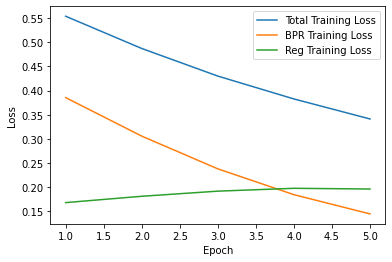

In [22]:
epoch_list = [(i+1) for i in range(EPOCHS)]

plt.plot(epoch_list, loss_history, label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()